In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


KeyError: ('torch', 'linalg.eigh')

Setting of the main hyper-parameters of the model¶


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Loading of the MNIST dataset.
We import the MNIST dataset from Keras. To speedup the evaluation of this demo we use only a small number of training and test images. Obviously, better results are achievable when using the full dataset.

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quantum circuit as a convolution kernel

We follow the scheme described in the introduction and represented in the figure at the top of this demo.

We initialize a PennyLane default.qubit device, simulating a system of  
4
  qubits. The associated qnode represents the quantum circuit consisting of:

1 an embedding layer of local  Ry  rotations (with angles scaled by a factor of  π );
2 a random circuit of n_layers;
3 a final measurement in the computational basis, estimating  4  expectation values.

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1 the image is divided into squares of  2×2  pixels.

2 each square is processed by the quantum circuit.

3 the 4  expectation values are mapped into 4 different channels of a single output pixel.

Note

This process halves the resolution of the input image. In the standard language of CNN, this would correspond to a convolution with a  
2×2   kernel and a stride equal to  2 .

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.



In [ ]:
import os

# Definir la ruta donde se guardarán los archivos
SAVE_PATH = "C:\\Users\\Pina\\_static\\demonstration_assets\\quanvolution\\"

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Guardar imágenes preprocesadas
    np.save(os.path.join(SAVE_PATH, "q_train_images.npy"), q_train_images)
    np.save(os.path.join(SAVE_PATH, "q_test_images.npy"), q_test_images)

# Cargar imágenes preprocesadas
q_train_images = np.load(os.path.join(SAVE_PATH, "q_train_images.npy"))
q_test_images = np.load(os.path.join(SAVE_PATH, "q_test_images.npy"))

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Pina\\_static\\demonstration_assets\\quanvolution\\q_train_images.npy'

Let us visualize the effect of the quantum convolution layer on a batch of samples:



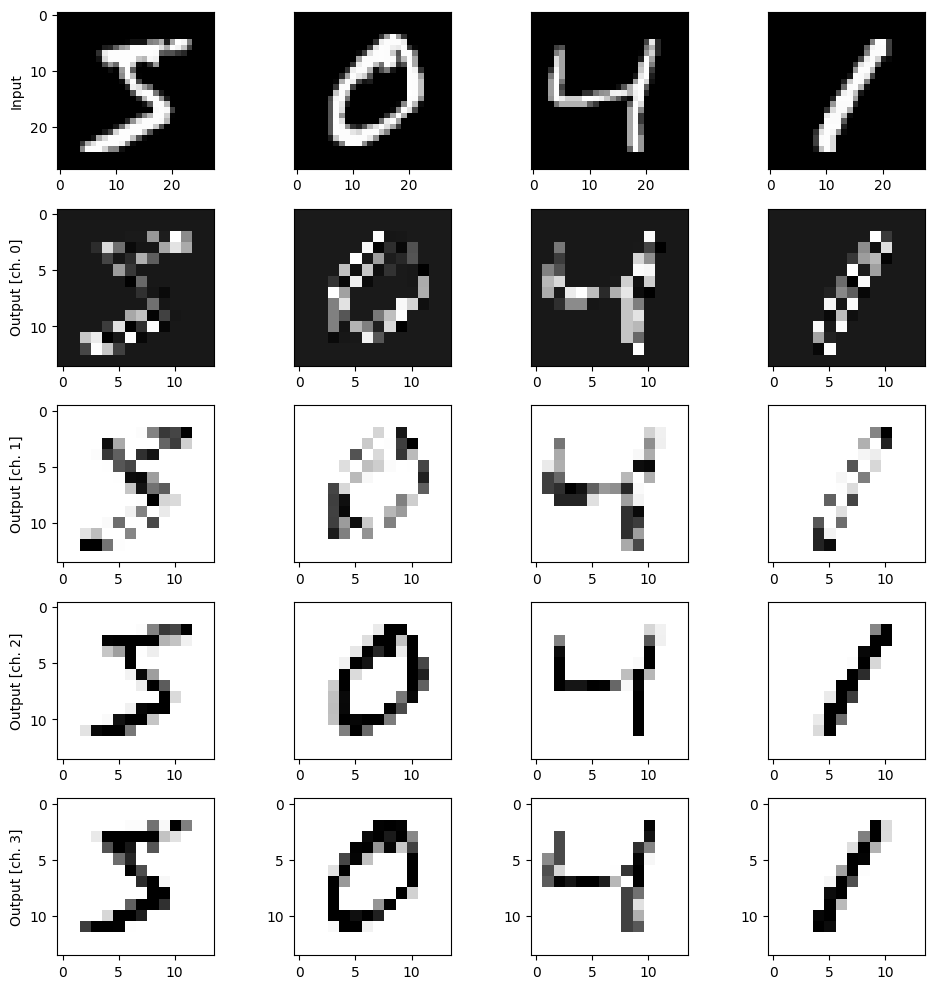

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the  4 output channels generated by the quantum convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local distortion introduced by the quantum kernel. On the other hand the global shape of the image is preserved, as expected for a convolution layer.

## Hybrid quantum-classical model.

After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the  
10
  different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.



In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 77ms/step - accuracy: 0.1400 - loss: 3.4565 - val_accuracy: 0.0667 - val_loss: 2.7023
Epoch 2/30
13/13 - 0s - 10ms/step - accuracy: 0.1800 - loss: 2.3110 - val_accuracy: 0.1000 - val_loss: 2.5163
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.4200 - loss: 1.8112 - val_accuracy: 0.2000 - val_loss: 2.3240
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.6200 - loss: 1.4379 - val_accuracy: 0.3000 - val_loss: 2.1524
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8000 - loss: 1.1473 - val_accuracy: 0.4000 - val_loss: 2.0095
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.9275 - val_accuracy: 0.4333 - val_loss: 1.9128
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.7616 - val_accuracy: 0.4667 - val_loss: 1.8193
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.6283 - val_accuracy: 0.4667 - val_loss: 1.7453
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.5270 - val_accuracy: 0.5000 - val_loss: 1.6869
Epoch 10/30
1

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).



In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 53ms/step - accuracy: 0.1600 - loss: 2.4252 - val_accuracy: 0.2667 - val_loss: 2.2418
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.3600 - loss: 2.0062 - val_accuracy: 0.3000 - val_loss: 2.1110
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.6200 - loss: 1.7139 - val_accuracy: 0.3667 - val_loss: 1.9887
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7800 - loss: 1.4724 - val_accuracy: 0.4333 - val_loss: 1.8720
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 1.2692 - val_accuracy: 0.4667 - val_loss: 1.7674
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 1.0995 - val_accuracy: 0.4667 - val_loss: 1.6781
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.9587 - val_accuracy: 0.4667 - val_loss: 1.6031
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.8417 - val_accuracy: 0.4667 - val_loss: 1.5399
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.7441 - val_accuracy: 0.4667 - val_loss: 1.4860
Epoch 10/30
13/13 

## Results
We can finally plot the test accuracy and the test loss with respect to the number of training epochs.



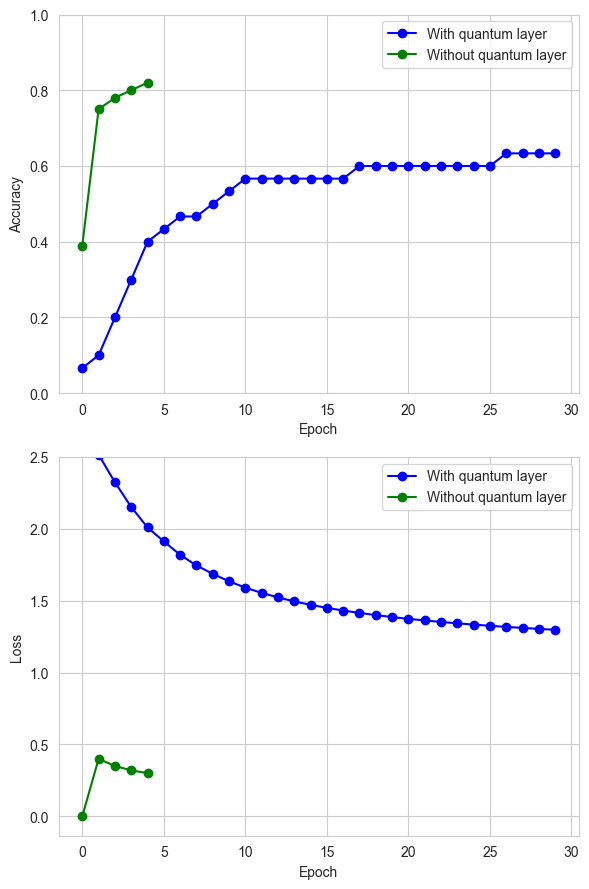

In [ ]:
# Suponiendo que c_history es un diccionario que contiene el historial de entrenamiento
c_history = {
    "val_accuracy": [0.39, 0.75, 0.78, 0.80, 0.82],
    "val_loss":  [0.0, 0.4, 0.35, 0.32, 0.30]
}

# Luego puedes continuar con tu código
import matplotlib.pyplot as plt
import seaborn as sns

# Configura el estilo de Seaborn en Matplotlib
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()  
plt.show()